In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Imports:
from comet_ml import Experiment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,CategoricalNB
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
import string
from sklearn import preprocessing
from sklearn.manifold import TSNE
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn import svm
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from time import time
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
import optuna
sns.set(context='notebook', style='darkgrid', palette='colorblind', font='sans-serif', font_scale=1, rc=None)
matplotlib.rcParams['figure.figsize'] =[8,8]
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['font.family'] = 'sans-serif'

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bartalisd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bartalisd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#Load data:
with open("../data_root.txt") as f:
    data_root_dir = f.read()
data_root_dir
train = pd.read_csv('%s/tweet_disaster/train.csv' % data_root_dir)
test = pd.read_csv('%s/tweet_disaster/test.csv' % data_root_dir)
#sub = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [4]:
#Analyse & clean data:
from data_analysis import analysis, data_cleaning
frame, train, vocabulary = analysis(train, test)
X, Y = data_cleaning(train, test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bartalisd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bartalisd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/bartalisd/git/apricot_exp/experiments/tweet_disaster/data_analysis.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text_length'] = train.text.apply(lambda x: len(x.split()))


In [5]:
#Train-test cut:
from apricot_exp.evaluation import traintest
X_train, X_test, Y_train, Y_test = traintest(X,Y,0.3)

In [6]:
#TFIDF & transpose data:
max_num_features = 10000
from data_analysis import tfidf
features_t, features_test_t = tfidf(X_train, X_test, max_num_features)
print(features_t.shape)
print(features_test_t.shape)

(10000, 5264)
(10000, 2257)


In [6]:
from apricot_exp.comet_utils import *
api_key = load_api_key('../../comet_key.txt')

In [8]:
#Bare model:
model = LogisticRegression(max_iter=1000)
n = 9000
experiment=init_experiment(api_key, 'tweet_disaster', 'apricot')
experiment.log_parameters({
    'size': None,
    'function': None,
})
tfidf = TfidfVectorizer(sublinear_tf=True,max_features=n, min_df=1, norm='l2',  ngram_range=(1,2))
features = tfidf.fit_transform(X_train).toarray()
features_test = tfidf.transform(X_test).toarray()
print(features.shape, features_test.shape)
from apricot_exp.evaluation import train_eval
train_eval(model, features,  Y_train, features_test, Y_test, experiment)
experiment.end()

COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/1fd1e6d092f54b7199900b2180e9f4b1



(5264, 9000) (2257, 9000)


COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


In [9]:
from apricot_exp.func_tp import featureb, facilityloc, maxcov
from comet import suggest_config, extract_grid

In [10]:
from optuna.samplers import TPESampler, RandomSampler, GridSampler
from parameters import param, algo
from apricot_exp.evaluation import train_eval

In [11]:
#Feature-based(naive, lazy, two-stage running time)
for i in [100, 500, 1000, 2500, 5000, 7500, 8000, 9000]:
    for j in ["naive", "lazy", "two-stage"]:
        experiment=init_experiment(api_key, 'tweet_disaster', 'apricot')
        n = i    
        start_time = time.time()
        Xtr_t, Xte_t = featureb(features_t, features_test_t, i, "sqrt", j)
        experiment.log_metric("running_time", time.time()-start_time)
        Xtr = Xtr_t.transpose()
        Xte = Xte_t.transpose()
        acc, pre, rec, roc = train_eval(model, Xtr, Y_train, Xte, Y_test, experiment)
        print(j)
        print(time.time()-start_time)
        experiment.log_parameters({
            'optimizer': j,
            'size': i,
            'function': 'featurebased'
        })
        experiment.end() 

COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/7d6f78b719ff48de9a0c8abd517b662f

COMET INFO: Still uploading


naive
8.883957386016846


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/c58ae00e7aa74150b48461585db4fb84

COMET INFO: Still uploading


lazy
5.935347080230713


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/4aee88119e8341ee89127ac68224290a

COMET INFO: Still uploading


two-stage
6.805429458618164


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/4009ffaa07c641a7b6d46483e6773c53

COMET INFO: Still uploading


naive
21.53317403793335


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/5eb3cb73ef0f4f8ea09cdd937afd92ad

COMET INFO: Still uploading


lazy
8.776475429534912


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/d9956c4c6cef4ee0baf0dcfbeae26253

COMET INFO: Still uploading


two-stage
24.756285667419434


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/b1666911cdd9432aa31ed2cc4e69d962

COMET INFO: Still uploading


naive
49.86116409301758


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/2795658ec0224b509b0aa7700e2a6e25

COMET INFO: Still uploading


lazy
24.49023127555847


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/839359c930b343c3bf7753d963cd8785

COMET INFO: Still uploading


two-stage
50.83109498023987


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/f992102f3fbb45cd82632deba315f5c8

COMET INFO: Still uploading


naive
216.6498670578003


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/e5651ae5ff0c4054a0774fa35f0637f8

COMET INFO: Still uploading


lazy
166.38418769836426


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/07e078f10ac7496b8cb551e08c19fb53

COMET INFO: Still uploading


two-stage
238.60188698768616


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/c594ed08e0f542bcab8eca10648a80be

COMET INFO: Still uploading


naive
783.258768081665


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/9965c5889416435fa8ee066866224e32

COMET INFO: Still uploading


lazy
670.4934828281403


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/2e5a2e6702cd4f90a06e9f191dd043a5

COMET INFO: Still uploading


two-stage
827.2879586219788


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/debed4e740c94f56b96bd082012793dc

COMET INFO: Still uploading


naive
1729.0269129276276


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/c52d0d959e4c49f99a1cb074ae9425c3

COMET INFO: Still uploading


lazy
1537.4941442012787


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/771b958e14644844b9ccf221a08f8d04

COMET INFO: Still uploading


two-stage
1780.882728099823


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/0bc3bacbb64e4e65a2cb43b6449e2d4b

COMET INFO: Still uploading


naive
1917.6446788311005


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/3886a1b437954bc9a3853deca88bde76

COMET INFO: Still uploading


lazy
1725.3056592941284


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/beb0703b21784a94ac173e2ab53e0472

COMET INFO: Still uploading


two-stage
2019.609894990921


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/e6c77477990b4a5ba65fef046ceb32f6

COMET INFO: Still uploading


naive
2465.3778603076935


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/b98ac3748889422587c16a8607e4da9a

COMET INFO: Still uploading


lazy
2196.1041157245636


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/7b6db85758e8479aa24cf4cc5917d1d4

COMET INFO: Still uploading


two-stage
2541.78133559227


In [ ]:
#Feature-based(approximate-lazy, stochastic, sample)
#A 7500 Sample-ből kell majd még 4 db!!
for i in [8000, 9000]:
    for j in ["approximate-lazy", "stochastic", "sample"]:
        for k in range(10):
            experiment=init_experiment(api_key, 'tweet_disaster', 'apricot')
            n = i    
            start_time = time.time()
            Xtr_t, Xte_t = featureb(features_t, features_test_t, i, "sqrt", j)
            experiment.log_metric("running_time", time.time()-start_time)
            Xtr = Xtr_t.transpose()
            Xte = Xte_t.transpose()
            acc, pre, rec, roc = train_eval(model, Xtr, Y_train, Xte, Y_test, experiment)
            print(j)
            print(time.time()-start_time)
            experiment.log_parameters({
                'optimizer': j,
                'size': i,
                'function': 'featurebased'
            })
            experiment.end() 

COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/d443a361bcc046609ab4a8f887ae76c7

COMET INFO: Still uploading


approximate-lazy
2001.5409181118011


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/39be70a012664aec98e07652a6d3a898

COMET INFO: Still uploading


approximate-lazy
1971.9072539806366


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/3ca520e9e0684e869b4d018572219099



approximate-lazy
2003.9449169635773


COMET INFO: Still uploading
COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/590777b444b249ba917023be7af0ce18

COMET INFO: Still uploading


approximate-lazy
2005.1018278598785


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/934f98521b4f48d8b502b59bdf1950b5

COMET INFO: Still uploading


approximate-lazy
1975.2666187286377


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/76b59cc09d144395837c401b7f03149c

COMET INFO: Still uploading


approximate-lazy
1976.0223591327667


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/0f5eaf9cebea4c27bf633d0086d0e57a

COMET INFO: Still uploading


approximate-lazy
1982.5409018993378


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/ad961e1edaf8459cb16ae7077496ad43

COMET INFO: Still uploading


approximate-lazy
1957.3004179000854


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/358d462fee8a42909ad271b3eefcd260

COMET INFO: Still uploading


approximate-lazy
1954.7998971939087


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/0002cf404d334d678869639e7c63c406

COMET INFO: Still uploading


approximate-lazy
1959.0744278430939


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/20ddfcb21c9748399ffb11793a9c31a2

COMET INFO: Still uploading


stochastic
1916.6204404830933


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/015975835df94ec88a1bd7d0f10affcd

COMET INFO: Still uploading


stochastic
1895.5367949008942


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/98c3116a237840e6ad67f9fc64d13cb8

COMET INFO: Still uploading


stochastic
1920.0947942733765


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/8291a2eb1ad84c58b354c3d856c0bbef



In [ ]:
parameters = param('featurebased')
search_alg = "GRID"
algo = algo(search_alg, parameters)
for i in [100, 500, 1000, 2500, 5000, 7500, 8000, 9000]:
    experiment=init_experiment(api_key, 'tweet_disaster', 'apricot')
    n = i    
    def objective(trial):
        config = suggest_config(parameters, trial)
        roc=0.0
        try:
            start_time = time.time()
            Xtr_t, Xte_t = featureb(features_t, features_test_t, i, config["function"], config["optimizer"])
            experiment.log_metric("running_time", time.time()-start_time)
            Xtr = Xtr_t.transpose()
            Xte = Xte_t.transpose()
            acc, pre, rec, roc = train_eval(model, Xtr, Y_train, Xte, Y_test, experiment)
        except Exception as err:
            print(err)
        finally:   
            return roc
    study = optuna.create_study(direction="maximize", sampler=algo)
    study.optimize(objective, n_trials=20, n_jobs=1)
    best_param = study.best_params
    print(best_param)
    experiment.log_parameters({
        'best param': best_param,
        'size': i,
        'function': 'featurebased'
    })
    experiment.end()

COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/7836e005f3324b82897bcb79ee7ec2c9

[I 2021-11-22 20:42:57,278] A new study created in memory with name: no-name-16205216-c4a4-4bcb-8ff9-725e05296b94
[I 2021-11-22 20:43:06,137] Trial 0 finished with value: 0.7557121038502888 and parameters: {'function': 'log', 'optimizer': 'sample'}. Best is trial 0 with value: 0.7557121038502888.
[I 2021-11-22 20:43:13,633] Trial 1 finished with value: 0.6248430851235041 and parameters: {'function': 'log', 'optimizer': 'stochastic'}. Best is trial 0 with value: 0.7557121038502888.
[I 2021-11-22 20:43:26,050] Trial 2 finished with value: 0.7464798762706081 and parameters: {'function': 'sqrt', 'optimizer': 'sample'}. Best is trial 0 with value: 0.7557121038502888.
[I 2021-11-22 20:43:36,055] Trial 3 finished with value: 0.7481033417235852 and paramete

{'function': 'log', 'optimizer': 'lazy'}


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/08e87ef197484d72b7c0297360c7ac06

[I 2021-11-22 20:44:06,699] A new study created in memory with name: no-name-8401a985-61a7-490b-8c76-ba3ba8d11a5c
[I 2021-11-22 20:44:44,455] Trial 0 finished with value: 0.8349694056225416 and parameters: {'function': 'sqrt', 'optimizer': 'approximate-lazy'}. Best is trial 0 with value: 0.8349694056225416.
[I 2021-11-22 20:44:53,227] Trial 1 finished with value: 0.8358879611687986 and parameters: {'function': 'log', 'optimizer': 'lazy'}. Best is trial 1 with value: 0.8358879611687986.
[I 2021-11-22 20:45:42,300] Trial 2 finished with value: 0.8300265870129201 and parameters: {'function': 'sqrt', 'optimizer': 'sample'}. Best is trial 1 with value: 0.8358879611687986.
[I 2021-11-22 20:45:51,097] Trial 3 finished with value: 0.8359370473609331 and par

{'function': 'log', 'optimizer': 'approximate-lazy'}


COMET INFO: Still uploading
COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/b2e3560ce52a4d268b4484635d458519

[I 2021-11-22 20:47:32,773] A new study created in memory with name: no-name-95ae24b4-83b5-4115-87b8-cdf1a9c2a213
[I 2021-11-22 20:48:18,501] Trial 0 finished with value: 0.6889983358976174 and parameters: {'function': 'log', 'optimizer': 'stochastic'}. Best is trial 0 with value: 0.6889983358976174.
[I 2021-11-22 20:49:02,007] Trial 1 finished with value: 0.7079262934613973 and parameters: {'function': 'sqrt', 'optimizer': 'stochastic'}. Best is trial 1 with value: 0.7079262934613973.
[I 2021-11-22 20:49:26,911] Trial 2 finished with value: 0.848897411467822 and parameters: {'function': 'log', 'optimizer': 'lazy'}. Best is trial 2 with value: 0.848897411467822.
[I 2021-11-22 20:50:47,726] Trial 3 finished with value: 0.8

{'function': 'sqrt', 'optimizer': 'approximate-lazy'}


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/6a87f651c949424e8d7e30890242c430

[I 2021-11-22 20:54:53,448] A new study created in memory with name: no-name-2d185442-87c8-46ed-b38f-df30db16244c
[I 2021-11-22 20:58:29,368] Trial 0 finished with value: 0.7731099401953148 and parameters: {'function': 'sqrt', 'optimizer': 'stochastic'}. Best is trial 0 with value: 0.7731099401953148.
[I 2021-11-22 21:02:55,885] Trial 1 finished with value: 0.8593785205260751 and parameters: {'function': 'log', 'optimizer': 'approximate-lazy'}. Best is trial 1 with value: 0.8593785205260751.
[I 2021-11-22 21:08:45,591] Trial 2 finished with value: 0.8592199962662307 and parameters: {'function': 'sqrt', 'optimizer': 'approximate-lazy'}. Best is trial 1 with value: 0.8593785205260751.
[I 2021-11-22 21:12:17,751] Trial 3 finished with value: 0.78539476

{'function': 'log', 'optimizer': 'approximate-lazy'}


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/9e4b52e13bb84df5b493dd2d829c6236

[I 2021-11-22 21:29:08,048] A new study created in memory with name: no-name-8533df46-2e7f-492c-8f36-50d33510320c
[I 2021-11-22 21:44:44,317] Trial 0 finished with value: 0.8605123310952175 and parameters: {'function': 'log', 'optimizer': 'approximate-lazy'}. Best is trial 0 with value: 0.8605123310952175.
[I 2021-11-22 21:56:08,446] Trial 1 finished with value: 0.860358634985419 and parameters: {'function': 'sqrt', 'optimizer': 'lazy'}. Best is trial 0 with value: 0.8605123310952175.
[I 2021-11-22 22:09:09,185] Trial 2 finished with value: 0.8177751562711233 and parameters: {'function': 'sqrt', 'optimizer': 'stochastic'}. Best is trial 0 with value: 0.8605123310952175.
[I 2021-11-22 22:20:35,408] Trial 3 finished with value: 0.860758566747565 and p

{'function': 'log', 'optimizer': 'lazy'}


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/16186434ca934e51842bd6311daf9c94

[I 2021-11-22 23:22:09,687] A new study created in memory with name: no-name-2b2e5d10-b2ec-448b-bafc-d158b81b6036
[I 2021-11-22 23:47:36,292] Trial 0 finished with value: 0.8617499468903496 and parameters: {'function': 'sqrt', 'optimizer': 'lazy'}. Best is trial 0 with value: 0.8617499468903496.
[I 2021-11-23 00:16:07,225] Trial 1 finished with value: 0.8467722207558952 and parameters: {'function': 'log', 'optimizer': 'stochastic'}. Best is trial 0 with value: 0.8617499468903496.
[I 2021-11-23 00:47:19,174] Trial 2 finished with value: 0.8616928137814714 and parameters: {'function': 'log', 'optimizer': 'approximate-lazy'}. Best is trial 0 with value: 0.8617499468903496.
[I 2021-11-23 01:15:45,827] Trial 3 finished with value: 0.8455486870650641 and 

In [11]:
parameters = param('facilitylocation')
search_alg = "RND"
algo = algo(search_alg, parameters)
for i in [100, 500, 1000, 2500, 5000, 7500, 8000, 9000]:
    experiment=init_experiment(api_key, 'tweet_disaster', 'apricot')
    n = i    
    def objective(trial):
        config = suggest_config(parameters, trial)
        roc=0.0
        try:
            start_time = time.time()
            Xtr_t, Xte_t = facilityloc(features_t, features_test_t, i, config["function"], "lazy")
            experiment.log_metric("running_time", time.time()-start_time)
            Xtr = Xtr_t.transpose()
            Xte = Xte_t.transpose()
            acc, pre, rec, roc = train_eval(model, Xtr, Y_train, Xte, Y_test, experiment)
        except Exception as err:
            print(err)
        finally:   
            return roc
    study = optuna.create_study(direction="maximize", sampler=algo)
    study.optimize(objective, n_trials=20, n_jobs=1)
    best_param = study.best_params
    print(best_param)
    experiment.log_parameters({
        'best param': best_param,
        'size': i,
        'function': 'facilitylocation'
    })
    experiment.end()

COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/5f2b18ff6b38492d9bdd391200b7181d

[I 2021-11-15 21:01:44,753] A new study created in memory with name: no-name-14257891-c2e9-4d6c-9b91-10d6c563efe5
[I 2021-11-15 21:01:44,763] Trial 0 finished with value: 0.0 and parameters: {'function': 'l1'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:44,769] Trial 1 finished with value: 0.0 and parameters: {'function': 'l1'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:44,776] Trial 2 finished with value: 0.0 and parameters: {'function': 'cosine'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:44,789] Trial 3 finished with value: 0.0 and parameters: {'function': 'correlation'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:44,795] Trial 4 finished with value: 0.0 and parameters: {'function': 'cityblock'}. Best is 

initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subs

COMET INFO: Still uploading
COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/ff9a57d8b0564a22a9f30be244e9bf24

[I 2021-11-15 21:01:47,912] A new study created in memory with name: no-name-09debaf8-dd76-4027-902a-0dcbfee91f78
[I 2021-11-15 21:01:47,918] Trial 0 finished with value: 0.0 and parameters: {'function': 'correlation'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:47,923] Trial 1 finished with value: 0.0 and parameters: {'function': 'l1'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:47,929] Trial 2 finished with value: 0.0 and parameters: {'function': 'cityblock'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:47,935] Trial 3 finished with value: 0.0 and parameters: {'function': 'l2'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:47,940] Trial 4 finished with value: 0.0 and parameters: {'fu

initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subs

COMET INFO: Still uploading
COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/84af3ee3c4af4576b5793046af2eb9d0

[I 2021-11-15 21:01:51,368] A new study created in memory with name: no-name-a90e0dd9-ee8f-46f1-bc30-1c91efa66ba2
[I 2021-11-15 21:01:51,375] Trial 0 finished with value: 0.0 and parameters: {'function': 'l2'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:51,382] Trial 1 finished with value: 0.0 and parameters: {'function': 'manhattan'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:51,385] Trial 2 finished with value: 0.0 and parameters: {'function': 'cosine'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:51,391] Trial 3 finished with value: 0.0 and parameters: {'function': 'l1'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:51,396] Trial 4 finished with value: 0.0 and parameters: {'functio

initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subs

COMET INFO: Still uploading
COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/0ff3bb063e494ff398f974afa16a5736

[I 2021-11-15 21:01:57,305] A new study created in memory with name: no-name-34a8a321-0c91-46d3-b41f-2fe331e0cd7f
[I 2021-11-15 21:01:57,314] Trial 0 finished with value: 0.0 and parameters: {'function': 'manhattan'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:57,320] Trial 1 finished with value: 0.0 and parameters: {'function': 'l1'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:57,324] Trial 2 finished with value: 0.0 and parameters: {'function': 'correlation'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:57,329] Trial 3 finished with value: 0.0 and parameters: {'function': 'euclidean'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:01:57,333] Trial 4 finished with value: 0.0 and parameter

initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subs

COMET INFO: Still uploading
COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/5639ad1b0b1c4f6493f78ee9f80e760e

[I 2021-11-15 21:02:04,995] A new study created in memory with name: no-name-9360efdb-715e-400d-af40-079b3b32d75c
[I 2021-11-15 21:02:05,003] Trial 0 finished with value: 0.0 and parameters: {'function': 'correlation'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:05,008] Trial 1 finished with value: 0.0 and parameters: {'function': 'l1'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:05,013] Trial 2 finished with value: 0.0 and parameters: {'function': 'l1'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:05,024] Trial 3 finished with value: 0.0 and parameters: {'function': 'euclidean'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:05,037] Trial 4 finished with value: 0.0 and parameters: {'fu

initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subs

COMET INFO: Still uploading
COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/ff3b431257d14acdaaa21b2a96e83d17

[I 2021-11-15 21:02:08,250] A new study created in memory with name: no-name-7998b60a-23db-476d-afac-f7f8d1d4779d
[I 2021-11-15 21:02:08,255] Trial 0 finished with value: 0.0 and parameters: {'function': 'correlation'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:08,263] Trial 1 finished with value: 0.0 and parameters: {'function': 'manhattan'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:08,271] Trial 2 finished with value: 0.0 and parameters: {'function': 'cityblock'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:08,274] Trial 3 finished with value: 0.0 and parameters: {'function': 'cosine'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:08,281] Trial 4 finished with value: 0.0 and param

initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subs

COMET INFO: Still uploading
COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/8727ba49c5074af2b65cca7430518963

[I 2021-11-15 21:02:16,196] A new study created in memory with name: no-name-2034b1b1-a083-4e3c-9f47-0872c34111f5
[I 2021-11-15 21:02:16,204] Trial 0 finished with value: 0.0 and parameters: {'function': 'manhattan'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:16,211] Trial 1 finished with value: 0.0 and parameters: {'function': 'l2'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:16,217] Trial 2 finished with value: 0.0 and parameters: {'function': 'correlation'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:16,224] Trial 3 finished with value: 0.0 and parameters: {'function': 'euclidean'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:16,228] Trial 4 finished with value: 0.0 and parameter

initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subs

COMET INFO: Still uploading
COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/ea49387bfc6b4be9935cfcb6c66df657

[I 2021-11-15 21:02:22,761] A new study created in memory with name: no-name-426f35d3-0b13-416b-8b30-11aa9b25e471
[I 2021-11-15 21:02:22,768] Trial 0 finished with value: 0.0 and parameters: {'function': 'correlation'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:22,773] Trial 1 finished with value: 0.0 and parameters: {'function': 'euclidean'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:22,777] Trial 2 finished with value: 0.0 and parameters: {'function': 'l1'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:22,783] Trial 3 finished with value: 0.0 and parameters: {'function': 'l2'}. Best is trial 0 with value: 0.0.
[I 2021-11-15 21:02:22,787] Trial 4 finished with value: 0.0 and parameters: {'fu

initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subset must be a list, numpy array, or None
initial_subs

COMET INFO: Still uploading


In [ ]:
parameters = param('maxcoverage')
search_alg = "GRID"
algo = algo(search_alg, parameters)
for i in [100, 500, 1000, 2500, 5000, 7500, 8000, 9000]:
    experiment=init_experiment(api_key, 'tweet_disaster', 'apricot')
    experiment.log_parameters({
        'size': i,
        'function': 'maxcoverage'
    })
    n = i    
    def objective(trial):
        config = suggest_config(parameters, trial)
        roc=0.0
        try:
            start_time = time.time()
            Xtr_t, Xte_t = maxcov(features_t, features_test_t, i, "two_stage")
            experiment.log_metric("running_time", time.time()-start_time)
            Xtr = Xtr_t.transpose()
            Xte = Xte_t.transpose()
            acc, pre, rec, roc = train_eval(model, Xtr, Y_train, Xte, Y_test, experiment)
        except Exception as err:
            print(err)
        finally:   
            return roc
    study = optuna.create_study(direction="maximize", sampler=algo)
    study.optimize(objective, n_trials=20, n_jobs=1)
    best_param = study.best_params
    print(best_param)
    experiment.log_parameters({
        'best param': best_param,
        'size': i,
        'function': 'maxcoverage'
    })
    experiment.end()

COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/615ccb1b91d0406db168c51db259bac2

[I 2021-11-15 21:12:43,740] A new study created in memory with name: no-name-6ff6a5b4-6c09-48c9-b978-fff6b444b865
[I 2021-11-15 21:12:50,326] Trial 0 finished with value: 0.0 and parameters: {'optimizer': 'stochastic'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:12:56,845] Trial 1 finished with value: 0.0 and parameters: {'optimizer': 'bidirectional'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:13:03,040] Trial 2 finished with value: 0.0 and parameters: {'optimizer': 'random'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:13:09,487] Trial 3 finished with value: 0.0 and parameters: {'optimizer': 'lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:13:15,985] Trial 4 finished with value: 0.0 and parameters: {'optimizer': 'two-stage'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:13:22,197] Trial 5 finished with value: 0.0 and parameters: {'optimizer': 'sample'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:13:28,767] Trial 6 finished with value: 0.0 and parameters: {'optimizer': 'modular'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:13:34,913] Trial 7 finished with value: 0.0 and parameters: {'optimizer': 'approximate-lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:13:41,289] Trial 8 finished with value: 0.0 and parameters: {'optimizer': 'naive'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:13:47,301] Trial 9 finished with value: 0.0 and parameters: {'optimizer': 'greedi'}. Best is trial 0 with value: 0.0.
COMET INFO: Still uploading


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)
{'optimizer': 'stochastic'}


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/e709572b295d4e2281b9e9606dd1614e

[I 2021-11-15 21:13:54,105] A new study created in memory with name: no-name-5904779a-ee20-462b-92e0-8a265f1a2bb7
[I 2021-11-15 21:14:00,739] Trial 0 finished with value: 0.0 and parameters: {'optimizer': 'random'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:14:07,319] Trial 1 finished with value: 0.0 and parameters: {'optimizer': 'modular'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:14:13,508] Trial 2 finished with value: 0.0 and parameters: {'optimizer': 'naive'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:14:20,142] Trial 3 finished with value: 0.0 and parameters: {'optimizer': 'lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:14:26,385] Trial 4 finished with value: 0.0 and parameters: {'optimizer': 'stochastic'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:14:33,002] Trial 5 finished with value: 0.0 and parameters: {'optimizer': 'greedi'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:14:39,133] Trial 6 finished with value: 0.0 and parameters: {'optimizer': 'two-stage'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:14:45,684] Trial 7 finished with value: 0.0 and parameters: {'optimizer': 'approximate-lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:14:52,306] Trial 8 finished with value: 0.0 and parameters: {'optimizer': 'sample'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:14:58,446] Trial 9 finished with value: 0.0 and parameters: {'optimizer': 'bidirectional'}. Best is trial 0 with value: 0.0.
COMET INFO: Still uploading


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)
{'optimizer': 'random'}


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/e09c10b372da4bafb7e573c9c7fd36ba

[I 2021-11-15 21:15:03,264] A new study created in memory with name: no-name-df05065f-1635-4803-89fa-168c22d9637d
[I 2021-11-15 21:15:10,004] Trial 0 finished with value: 0.0 and parameters: {'optimizer': 'greedi'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:15:16,315] Trial 1 finished with value: 0.0 and parameters: {'optimizer': 'random'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:15:44,196] Trial 2 finished with value: 0.0 and parameters: {'optimizer': 'bidirectional'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:15:50,284] Trial 3 finished with value: 0.0 and parameters: {'optimizer': 'approximate-lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:15:56,868] Trial 4 finished with value: 0.0 and parameters: {'optimizer': 'stochastic'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:16:03,376] Trial 5 finished with value: 0.0 and parameters: {'optimizer': 'two-stage'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:16:09,496] Trial 6 finished with value: 0.0 and parameters: {'optimizer': 'modular'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:16:15,980] Trial 7 finished with value: 0.0 and parameters: {'optimizer': 'lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:16:22,050] Trial 8 finished with value: 0.0 and parameters: {'optimizer': 'naive'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:16:28,642] Trial 9 finished with value: 0.0 and parameters: {'optimizer': 'sample'}. Best is trial 0 with value: 0.0.
COMET INFO: Still uploading


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)
{'optimizer': 'greedi'}


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/9a8955061fa24465951c190387963638

[I 2021-11-15 21:16:33,008] A new study created in memory with name: no-name-ee1f0977-6cab-4458-9b21-28f0ff0d3bfa
[I 2021-11-15 21:16:39,167] Trial 0 finished with value: 0.0 and parameters: {'optimizer': 'approximate-lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:16:45,727] Trial 1 finished with value: 0.0 and parameters: {'optimizer': 'lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:16:51,923] Trial 2 finished with value: 0.0 and parameters: {'optimizer': 'modular'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:16:58,662] Trial 3 finished with value: 0.0 and parameters: {'optimizer': 'two-stage'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:17:04,739] Trial 4 finished with value: 0.0 and parameters: {'optimizer': 'sample'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:17:11,237] Trial 5 finished with value: 0.0 and parameters: {'optimizer': 'random'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:17:17,645] Trial 6 finished with value: 0.0 and parameters: {'optimizer': 'bidirectional'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:17:23,710] Trial 7 finished with value: 0.0 and parameters: {'optimizer': 'greedi'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:17:30,257] Trial 8 finished with value: 0.0 and parameters: {'optimizer': 'stochastic'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:17:36,338] Trial 9 finished with value: 0.0 and parameters: {'optimizer': 'naive'}. Best is trial 0 with value: 0.0.
COMET INFO: Still uploading


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)
{'optimizer': 'approximate-lazy'}


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/a4ae670c96fd49b0ada5471ef0a28e76

[I 2021-11-15 21:17:42,603] A new study created in memory with name: no-name-28ae9f3d-54ce-4d6f-9e72-0fba58a3acec
[I 2021-11-15 21:17:49,168] Trial 0 finished with value: 0.0 and parameters: {'optimizer': 'lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:17:55,337] Trial 1 finished with value: 0.0 and parameters: {'optimizer': 'approximate-lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:18:01,945] Trial 2 finished with value: 0.0 and parameters: {'optimizer': 'random'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:18:07,980] Trial 3 finished with value: 0.0 and parameters: {'optimizer': 'bidirectional'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:18:14,019] Trial 4 finished with value: 0.0 and parameters: {'optimizer': 'stochastic'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:18:20,546] Trial 5 finished with value: 0.0 and parameters: {'optimizer': 'sample'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:18:27,115] Trial 6 finished with value: 0.0 and parameters: {'optimizer': 'two-stage'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:18:33,181] Trial 7 finished with value: 0.0 and parameters: {'optimizer': 'modular'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:18:39,782] Trial 8 finished with value: 0.0 and parameters: {'optimizer': 'greedi'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:18:45,845] Trial 9 finished with value: 0.0 and parameters: {'optimizer': 'naive'}. Best is trial 0 with value: 0.0.
COMET INFO: Still uploading


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)
{'optimizer': 'lazy'}


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/bbca911ed9144f338b655c572fdf4a97

[I 2021-11-15 21:18:49,568] A new study created in memory with name: no-name-e2c473cd-8da4-4c22-ae36-d3d2937972a6
[I 2021-11-15 21:18:56,292] Trial 0 finished with value: 0.0 and parameters: {'optimizer': 'stochastic'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:19:02,468] Trial 1 finished with value: 0.0 and parameters: {'optimizer': 'sample'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:19:09,182] Trial 2 finished with value: 0.0 and parameters: {'optimizer': 'modular'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:19:15,364] Trial 3 finished with value: 0.0 and parameters: {'optimizer': 'approximate-lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:19:21,470] Trial 4 finished with value: 0.0 and parameters: {'optimizer': 'greedi'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:19:28,099] Trial 5 finished with value: 0.0 and parameters: {'optimizer': 'lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:19:34,673] Trial 6 finished with value: 0.0 and parameters: {'optimizer': 'naive'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:19:40,867] Trial 7 finished with value: 0.0 and parameters: {'optimizer': 'bidirectional'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:19:46,856] Trial 8 finished with value: 0.0 and parameters: {'optimizer': 'random'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:19:53,461] Trial 9 finished with value: 0.0 and parameters: {'optimizer': 'two-stage'}. Best is trial 0 with value: 0.0.
COMET INFO: Still uploading


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)
{'optimizer': 'stochastic'}


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/d47df841a5684c989bab4f7bb383260d

[I 2021-11-15 21:19:58,863] A new study created in memory with name: no-name-d5e5c9db-d878-4a0d-8200-1fa030dd95ff
[I 2021-11-15 21:20:05,817] Trial 0 finished with value: 0.0 and parameters: {'optimizer': 'bidirectional'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:20:12,116] Trial 1 finished with value: 0.0 and parameters: {'optimizer': 'sample'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:20:18,349] Trial 2 finished with value: 0.0 and parameters: {'optimizer': 'random'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:20:25,012] Trial 3 finished with value: 0.0 and parameters: {'optimizer': 'modular'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:20:31,070] Trial 4 finished with value: 0.0 and parameters: {'optimizer': 'lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:20:37,624] Trial 5 finished with value: 0.0 and parameters: {'optimizer': 'stochastic'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:20:43,763] Trial 6 finished with value: 0.0 and parameters: {'optimizer': 'naive'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:20:50,355] Trial 7 finished with value: 0.0 and parameters: {'optimizer': 'greedi'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:20:56,491] Trial 8 finished with value: 0.0 and parameters: {'optimizer': 'approximate-lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:21:03,081] Trial 9 finished with value: 0.0 and parameters: {'optimizer': 'two-stage'}. Best is trial 0 with value: 0.0.
COMET INFO: Still uploading


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)
{'optimizer': 'bidirectional'}


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/1296b684b93848a2868fbd8b1c5d8a81

[I 2021-11-15 21:21:07,010] A new study created in memory with name: no-name-83ff6f59-628c-4ef3-b08f-9730aa65fb52
[I 2021-11-15 21:21:13,202] Trial 0 finished with value: 0.0 and parameters: {'optimizer': 'lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:21:19,996] Trial 1 finished with value: 0.0 and parameters: {'optimizer': 'modular'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:21:26,213] Trial 2 finished with value: 0.0 and parameters: {'optimizer': 'approximate-lazy'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


[I 2021-11-15 21:21:32,434] Trial 3 finished with value: 0.0 and parameters: {'optimizer': 'stochastic'}. Best is trial 0 with value: 0.0.


No matching definition for argument type(s) array(float64, 1d, C), array(int32, 1d, C), array(int32, 1d, C), array(float64, 1d, C), array(float64, 1d, C), unicode_type, array(int64, 1d, C)


In [ ]:
def randomtrain(X_tr, X_te, n):
    X_train_arr = X_tr.to_numpy()
    X_test_arr = X_te.to_numpy() 
    print(X_train_arr.shape, X_test_arr.shape)
    idxs = np.arange(X_tr.shape[0])
    np.random.shuffle(idxs)
    idx = idxs[:n]
    Xtr, Xte = X_train_arr[idx,:], X_test_arr[idx,:]
    return Xtr, Xte

In [ ]:
for j in [100, 500, 1000, 2500, 5000, 7500, 8000, 9000]: 
    for i in range(1,20):
        n = j
        experiment=init_experiment(api_key, 'tweet_disaster', 'apricot')
        experiment.log_parameters({
            'size': i,
            'function': 'random'
        })
        Xtr_t, Xte_t = randomtrain(features_t, features_test_t, n)
        Xtr = Xtr_t.transpose()
        Xte = Xte_t.transpose()
        from apricot_exp.evaluation import train_eval
        train_eval(model, Xtr, Y_train, Xte, Y_test, experiment)
        i = i+1
        experiment.end()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=20, max_depth=3)

In [ ]:
from apricot_exp.evaluation import train_eval
train_eval(model, features,  Y_train, features_test, Y_test, experiment)

## PCA

In [ ]:
#pca = PCA(n_components=2)

In [47]:
from sklearn.preprocessing import StandardScaler
f = list(range(0, 9000))
scaler = StandardScaler()
x = features[:, f]
x = scaler.fit_transform(x)
#x = pd.DataFrame(x)
x_test = scaler.transform(features_test)

In [48]:
from sklearn.decomposition import PCA
for i in [100, 500, 1000, 2500, 5000]:#, 7500, 8000, 9000]: 
    experiment=init_experiment(api_key, 'tweet_disaster', 'apricot')
    start_time = time.time()
    pca = PCA(n_components=i)
    x_pca = pca.fit_transform(x)
    x_pca = pd.DataFrame(x_pca)
    experiment.log_metric("running_time", time.time()-start_time)
    x_pca.head()
    x_test_pca = pca.transform(x_test)
    x_test_pca = pd.DataFrame(x_test_pca)
    acc, pre, rec, roc = train_eval(model, x_pca, Y_train, x_test_pca, Y_test, experiment)
    print(roc)
    print(i)
    print(time.time()-start_time)
    experiment.log_parameters({
                'size': i,
                'function': 'PCA'
            })
    experiment.end()

COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/d233d6e8e45c4f2cb8ac908576cf5a57

COMET INFO: Still uploading


0.7614592117884111
100
8.749795198440552


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/6faa8b1f33ad4019a03fc98b8653eb2d

COMET INFO: Still uploading


0.8290050309323479
500
26.015256643295288


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/57f41dbd677e43ff9c82fa4093fde326

COMET INFO: Still uploading


0.8321895982335408
1000
35.86195659637451


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/eae6fb79aa514798a90b61ac427216e2

COMET INFO: Still uploading


0.7852350343442407
2500
155.57972025871277


COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/153c4bf727b745aa99c8d810408f6ff9

COMET INFO: Still uploading


0.7820025878884247
5000
309.1756064891815


## Visualization

In [72]:
from comet_ml.api import API, APIExperiment
api=API(api_key)

In [73]:
experiments = api.get(workspace = "apricot", project_name = "tweet-disaster")

In [74]:
print(experiments[1])

<APIExperiment 'apricot/tweet-disaster/3ba97a0d73f54124ac386a67910876dc'>


In [77]:
df = pd.DataFrame()
for i in range(307):
    exp_param = experiments[i].get_parameters_summary()
    exp_metrics = experiments[i].get_metrics_summary()
    function = next(item for item in exp_param if item["name"] == "function")
    function_name = function['valueMax']
    size = next(item for item in exp_param if item["name"] == "size")
    size_value = size['valueMax']
    acc = next(item for item in exp_metrics if item["name"] == "acc")
    acc_value = acc['valueMax']
    pre = next(item for item in exp_metrics if item["name"] == "pre")
    pre_value = pre['valueMax']
    rec = next(item for item in exp_metrics if item["name"] == "rec")
    rec_value = rec['valueMax']
    roc = next(item for item in exp_metrics if item["name"] == "roc")
    roc_value = roc['valueMax']
    time = next(item for item in exp_metrics if item["name"] == "running_time")
    time_value = time['valueMax']
    dictionary = {'Function': function_name, 'Size': size_value, 'Accuracy': acc_value, 'Precision': pre_value, 'Recall': rec_value, 'AUC': roc_value, 'Running time': time_value }
    df = df.append(dictionary, ignore_index = True)

In [78]:
print(df)

                    AUC            Accuracy      Function           Precision  \
0    0.7580348463682656  0.7102348249889233  featurebased  0.7873563218390804   
1    0.8361193100251708  0.7704918032786885  featurebased  0.7966573816155988   
2    0.8491460611951924  0.7833407177669472  featurebased  0.8347826086956521   
3    0.8594324348682558  0.8001772264067346  featurebased  0.8302631578947368   
4    0.8607802934227721  0.7975188303057156  featurebased  0.8254593175853019   
..                  ...                 ...           ...                 ...   
302  0.8568228197683776  0.7992910943730616  featurebased  0.8238341968911918   
303  0.8529731747983442   0.793531236154187  featurebased  0.8166449934980494   
304  0.8522944173710402  0.7904297740363314  featurebased  0.8157894736842105   
305  0.8556403253529379  0.7930881701373504  featurebased  0.8248663101604278   
306  0.8561380271535157  0.7979618963225521  featurebased  0.8300132802124834   

                 Recall    

In [90]:
data=df.copy()
data['Size']=data['Size'].apply(lambda x: float(x))
data['percentage']=data['Size'].apply(lambda x: x / 100)
print(data)

                    AUC            Accuracy      Function           Precision  \
0    0.7580348463682656  0.7102348249889233  featurebased  0.7873563218390804   
1    0.8361193100251708  0.7704918032786885  featurebased  0.7966573816155988   
2    0.8491460611951924  0.7833407177669472  featurebased  0.8347826086956521   
3    0.8594324348682558  0.8001772264067346  featurebased  0.8302631578947368   
4    0.8607802934227721  0.7975188303057156  featurebased  0.8254593175853019   
..                  ...                 ...           ...                 ...   
302  0.8568228197683776  0.7992910943730616  featurebased  0.8238341968911918   
303  0.8529731747983442   0.793531236154187  featurebased  0.8166449934980494   
304  0.8522944173710402  0.7904297740363314  featurebased  0.8157894736842105   
305  0.8556403253529379  0.7930881701373504  featurebased  0.8248663101604278   
306  0.8561380271535157  0.7979618963225521  featurebased  0.8300132802124834   

                 Recall    

In [104]:
def lineplot_res(dataframe, y_name, metric, res5k, mod):
    data=dataframe.copy()
    data['Size']=data['Size'].apply(lambda x: float(x))
    data['percentage']=data['Size'].apply(lambda x: x / 100)
    functions=['featurebased', 'PCA']
    result=data[data['Function'].isin(functions)]
    #result=data.groupby(by=['Function','percentage'])[metric].mean().reset_index()
    ax=sns.lineplot(data=result, x='percentage', y=metric, hue='Function', palette=['yellow', 'b'])
    ax.set_title(mod,fontdict= { 'fontsize': 20, 'fontweight':'bold'})
    plt.xlabel('Number of features', fontsize= 15)
    plt.ylabel(y_name, fontsize= 15)
    plt.axhline(y=res5k, color='brown', linestyle='--')
    plt.setp(ax.get_legend().get_texts(), fontsize='15')
    plt.setp(ax.get_legend().get_title(), fontsize='20')
    return ax

<AxesSubplot:title={'center':'NLP - Disasters tweets: Dim reduction'}, xlabel='Number of features', ylabel='Accuracy'>

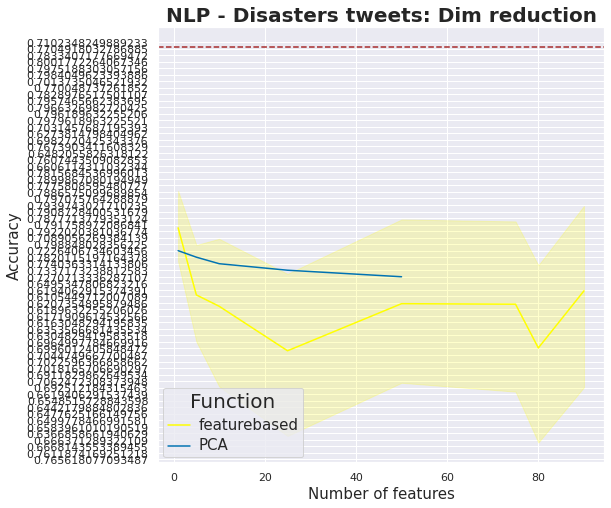

In [105]:
lineplot_res(df, 'Accuracy', 'Accuracy', 0.7984049623393886, 'NLP - Disasters tweets: Dim reduction' )

<AxesSubplot:title={'center':'NLP - Disasters tweets: Dim reduction'}, xlabel='Number of features', ylabel='Recall'>

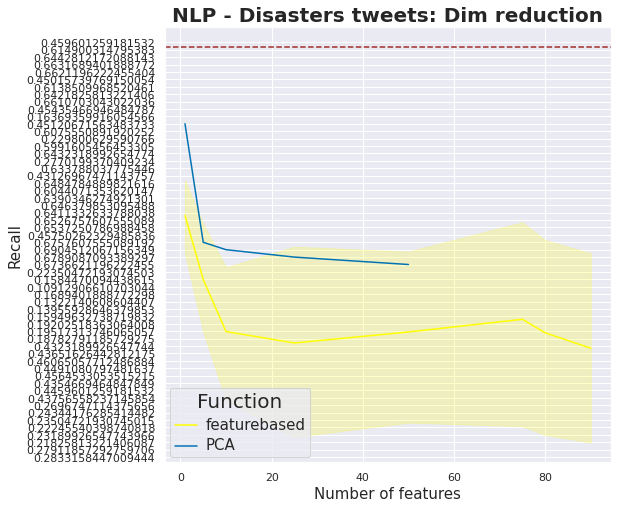

In [106]:
lineplot_res(df, 'Recall', 'Recall', 0.6621196222455404, 'NLP - Disasters tweets: Dim reduction' )

<AxesSubplot:title={'center':'NLP - Disasters tweets: Dim reduction'}, xlabel='Number of features', ylabel='Precision'>

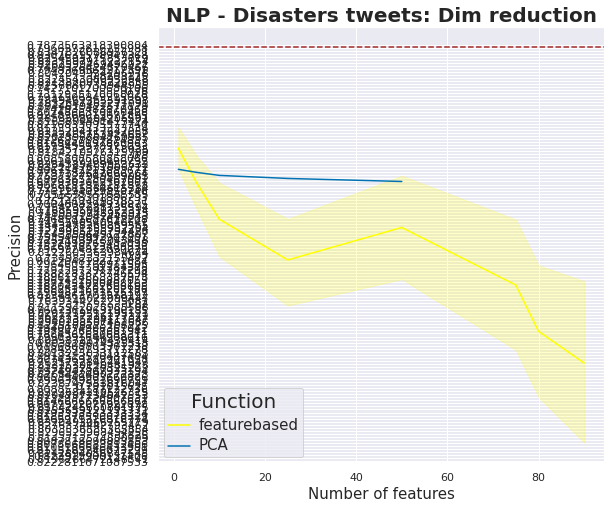

In [107]:
lineplot_res(df, 'Precision', 'Precision', 0.8259162303664922, 'NLP - Disasters tweets: Dim reduction' )

<AxesSubplot:title={'center':'NLP - Disasters tweets: Dim reduction'}, xlabel='Number of features', ylabel='ROC AUC'>

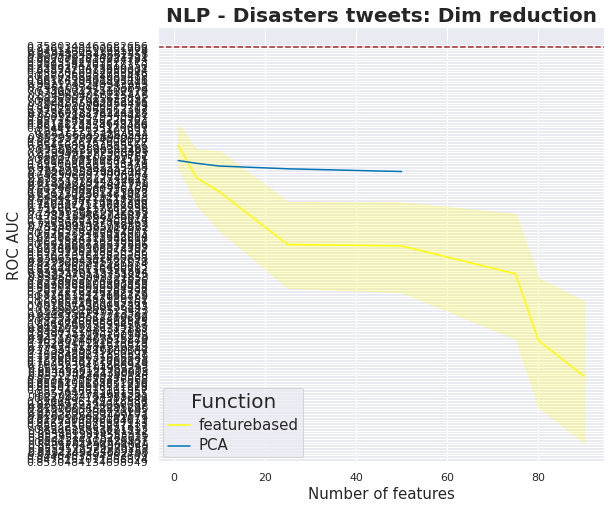

In [108]:
lineplot_res(df, 'ROC AUC', 'AUC', 0.8622086211447222, 'NLP - Disasters tweets: Dim reduction' )

<AxesSubplot:title={'center':'NLP - Disasters tweets: Dim reduction'}, xlabel='Number of features', ylabel='Running time'>

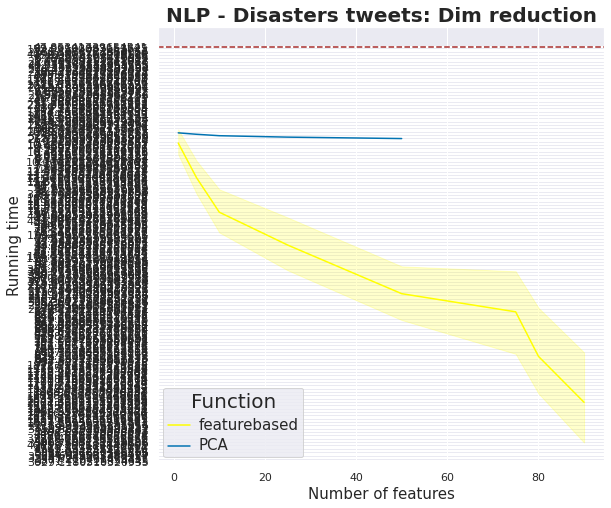

In [110]:
lineplot_res(df, 'Running time', 'Running time', 1, 'NLP - Disasters tweets: Dim reduction' )

In [31]:
proba=experiments[1].get_parameters_summary()
print(proba)

[{'name': 'best param', 'valueMax': '{"function": "sqrt", "optimizer": "greedi"}', 'valueMin': '{"function": "sqrt", "optimizer": "greedi"}', 'valueCurrent': '{"function": "sqrt", "optimizer": "greedi"}', 'timestampMax': 1636907213576, 'timestampMin': 1636907213576, 'timestampCurrent': 1636907213576, 'editable': False}, {'name': 'f', 'valueMax': '/home/bartalisd/.local/share/jupyter/runtime/kernel-16b40c94-313c-4b69-87fc-25a9e8706c7d.json', 'valueMin': '/home/bartalisd/.local/share/jupyter/runtime/kernel-16b40c94-313c-4b69-87fc-25a9e8706c7d.json', 'valueCurrent': '/home/bartalisd/.local/share/jupyter/runtime/kernel-16b40c94-313c-4b69-87fc-25a9e8706c7d.json', 'timestampMax': 1636906752638, 'timestampMin': 1636906752638, 'timestampCurrent': 1636906752638, 'editable': False}, {'name': 'function', 'valueMax': 'featurebased', 'valueMin': 'featurebased', 'valueCurrent': 'featurebased', 'timestampMax': 1636907213576, 'timestampMin': 1636907213576, 'timestampCurrent': 1636907213576, 'editable'

In [35]:
experiments[23].get_parameters_summary()

[{'name': 'f',
  'valueMax': '/home/bartalisd/.local/share/jupyter/runtime/kernel-16b40c94-313c-4b69-87fc-25a9e8706c7d.json',
  'valueMin': '/home/bartalisd/.local/share/jupyter/runtime/kernel-16b40c94-313c-4b69-87fc-25a9e8706c7d.json',
  'valueCurrent': '/home/bartalisd/.local/share/jupyter/runtime/kernel-16b40c94-313c-4b69-87fc-25a9e8706c7d.json',
  'timestampMax': 1637066854507,
  'timestampMin': 1637066854507,
  'timestampCurrent': 1637066854507,
  'editable': False},
 {'name': 'function',
  'valueMax': 'featurebased',
  'valueMin': 'featurebased',
  'valueCurrent': 'featurebased',
  'timestampMax': 1637068392486,
  'timestampMin': 1637068392486,
  'timestampCurrent': 1637068392486,
  'editable': False},
 {'name': 'optimizer',
  'valueMax': 'lazy',
  'valueMin': 'lazy',
  'valueCurrent': 'lazy',
  'timestampMax': 1637068392486,
  'timestampMin': 1637068392486,
  'timestampCurrent': 1637068392486,
  'editable': False},
 {'name': 'size',
  'valueMax': '7500',
  'valueMin': '7500',
  

In [42]:
proba2 = next(item for item in proba if item["name"] == "function")
print(proba2['valueMax'])

featurebased


In [21]:
df = pd.DataFrame.from_dict(dict)

In [62]:
experiments[161].get_metrics_summary()

[{'name': 'pre',
  'valueMax': '0.8248366013071895',
  'valueMin': '0.8248366013071895',
  'valueCurrent': '0.8248366013071895',
  'timestampMax': 1637666160373,
  'timestampMin': 1637666160373,
  'timestampCurrent': 1637666160373,
  'editable': False},
 {'name': 'rec',
  'valueMax': '0.6621196222455404',
  'valueMin': '0.6621196222455404',
  'valueCurrent': '0.6621196222455404',
  'timestampMax': 1637666160373,
  'timestampMin': 1637666160373,
  'timestampCurrent': 1637666160373,
  'editable': False},
 {'name': 'roc',
  'valueMax': '0.8592199962662307',
  'valueMin': '0.8592199962662307',
  'valueCurrent': '0.8592199962662307',
  'timestampMax': 1637666160373,
  'timestampMin': 1637666160373,
  'timestampCurrent': 1637666160373,
  'editable': False}]

In [ ]:
experiment.display(tab="tweet disaster")

In [ ]:
import neptune
project = neptune.init(project_qualified_name='bartalisd/nlp-disaster-tweets',
             api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNmY5YjdlNTgtNjMxNC00ODQyLThiNGItNmM5NTBmZTM1MjA4In0=', 
            )

# Download experiments dashboard as pandas DataFrame
data = project.get_leaderboard()

data=data[data['tags'].map(len) > 1]
data = data.drop(['name','created', 'finished','owner','notes', 'running_time','size'], axis=1)
for i in ['channel_roc', 'channel_acc', 'channel_rec', 'channel_pre']:
    data[i]=data[i].astype("float64")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def barplot_res(dataframe, percentage, metric, y_name):
    selector = dataframe.apply(lambda x: percentage in x["tags"], axis=1)
    data_percentage=dataframe.loc[selector, :]
    data_percentage["tags"]=data_percentage["tags"].apply(lambda x: str(x))
    res_percentage=data_percentage.groupby(by='tags')[metric].mean().reset_index()
    res_percentage['model']=res_percentage['tags'].apply(lambda x: eval(x)[1])
    ax=sns.barplot(data=res_percentage, x='model', y=metric)
    plt.ylim((0.5, 0.9))
    ax.set(xlabel='Model', ylabel=y_name, title =percentage)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    return ax, res_percentage
def lineplot_res(dataframe, y_name, metric, res5k, mod):
    data=dataframe.copy()
    data['percentage']=data['tags'].apply(lambda x: x[1])
    data=data[~data['percentage'].apply(lambda x: 'd' in str(x))]
    data['model']=data['tags'].apply(lambda x: x[0])
    functions=['facilityloc_d', 'featurebased_d', 'maxcov_d', 'random_d', 'Tfidf']
    data=data[data['model'].isin(functions)]
    result=data.groupby(by=['model','percentage'])[metric].mean().reset_index()
    ax=sns.lineplot(data=result, x='percentage', y=metric, hue='model', palette=['yellow', 'b','r','forestgreen','blueviolet'  ])
    ax.set_title(mod,fontdict= { 'fontsize': 20, 'fontweight':'bold'})
    plt.xlabel('Number of features', fontsize= 15)
    plt.ylabel(y_name, fontsize= 15)
    plt.axhline(y=res5k, color='brown', linestyle='--')
    plt.setp(ax.get_legend().get_texts(), fontsize='15')
    plt.setp(ax.get_legend().get_title(), fontsize='20')
    return ax

In [ ]:
lineplot_res(data, 'Accuracy', 'channel_acc', 0.7984049623393886, 'NLP - Disasters tweets: Dim reduction' )

In [ ]:
lineplot_res(data, 'Precision', 'channel_pre', 0.8259162303664922, 'NLP - Disasters tweets: Dim reduction' )

In [ ]:
lineplot_res(data, 'Recall', 'channel_rec', 0.6621196222455404, 'NLP - Disasters tweets: Dim reduction' )

In [ ]:
lineplot_res(data, 'ROC AUC', 'channel_roc', 0.8622086211447222, 'NLP - Disasters tweets: Dim reduction' )